In [1]:
# Cosas por hacer:
#    - Ejercicio eqwidth
#    - Ejercicio 3: no sé cómo cambiar elow y eup del simput


# Follows SIXTE tutorial

In [1]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
#xmldir="./xmldir"
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)

base = "mcrab"

# 10.2 General introduction to simulations with SIXTE



### 1) Create an xspec model and save it as mcrab.xcm

$\Gamma$=2.05, $Flux_{2-10}=2.16 \times 10^{-11}$, NH=$2\times 10^{21}$

In [4]:
# Example of a xspec file with the model "phabs*pegpwrlw"
base = "mcrab"
xcm = "{}.xcm".format(base)

mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 2.05
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()

rewrite = True
# If rewrite is true and the file exists, is is removed before creating a new one. This is due to some problems with the ftool fmerge
if rewrite:
    if os.path.exists(xcm):
            os.remove(xcm)
    Xset.save(xcm)
else:
    print("Xspec file ({}) already exists: it will not be overwritten".format(xcm)) 

### $\textbf{Exercise}$: add a narrow Gaussian iron line at an energy of 6.4 keV with an equivalent width of 150 eV to the spectrum. (Pendiente del comando eqwidth)

In [5]:

AllModels.eqwidth(3)


In [6]:



print(mcmod.componentNames)


print(AllModels.eqwidth(3))

mcmod.show()
if os.path.exists(xcm):
    print("Xspec file (", xcm, ") already exists: it will not be overwritten")
else:
    xspec.Xset.save(xcm)
    

['phabs', 'pegpwrlw']
None
Xspec file ( mcrab.xcm ) already exists: it will not be overwritten


### 2) Create SIMPUT FILE for source (``simputfile``)

In [16]:
simputfile = "{}.fits".format(base)

rewrite = True
if rewrite:
    if os.path.exists(simputfile):
            os.remove(simputfile)
    comm = ("simputfile Simput={} Src_Name=first RA=0. Dec=0. srcFlux=2.137E-11 Elow=0.1 Eup=15. Emin=2 Emax=10. XSPECFile=mcrab.xcm clobber=yes".format(simputfile))
    run_comm(comm, "Creating simputfile")
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simputfile))

Creating simputfile
simputfile Simput=mcrab.fits Src_Name=first RA=0. Dec=0. srcFlux=2.137E-11 Elow=0.1 Eup=15. Emin=2 Emax=10. XSPECFile=mcrab.xcm clobber=yes


### $\textbf{Exercise}$: generate a second SIMPUT file for our source, using the plPhoIndex, plFlux, and NH parameters rather than an xcm-file. Compare both SIMPUT-files using fv. Note this step only works if you have ISIS installed.


In [8]:
# --> Instalation of ISIS needed <--
simputfile = "{}_wo-xcm.fits".format(base)

rewrite = True
if rewrite:
    if os.path.exists(simputfile):
            os.remove(simputfile)
    comm = ("simputfile Simput={} Src_Name=first RA=0. Dec=0. srcFlux=2.137E-11 Elow=0.1 Eup=15. Emin=2 Emax=10.  clobber=yes plPhoIndex=2.05 plFlux=21.6 NH=0.2 ".format(simputfile))
    run_comm(comm, "Creating simputfile")
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simputfile))
    
f = fits.open(simputfile)
f.info()
f[1].columns.names

Creating simputfile
simputfile Simput=mcrab_wo-xcm.fits Src_Name=first RA=0. Dec=0. srcFlux=2.137E-11 Elow=0.1 Eup=15. Emin=2 Emax=10.  clobber=yes plPhoIndex=2.05 plFlux=21.6 NH=0.2 
Command '['simputfile', 'Simput=mcrab_wo-xcm.fits', 'Src_Name=first', 'RA=0.', 'Dec=0.', 'srcFlux=2.137E-11', 'Elow=0.1', 'Eup=15.', 'Emin=2', 'Emax=10.', 'clobber=yes', 'plPhoIndex=2.05', 'plFlux=21.6', 'NH=0.2']' returned non-zero exit status 1.


CalledProcessError: Command '['simputfile', 'Simput=mcrab_wo-xcm.fits', 'Src_Name=first', 'RA=0.', 'Dec=0.', 'srcFlux=2.137E-11', 'Elow=0.1', 'Eup=15.', 'Emin=2', 'Emax=10.', 'clobber=yes', 'plPhoIndex=2.05', 'plFlux=21.6', 'NH=0.2']' returned non-zero exit status 1.

## 3) Simulate with WFI one large chip (``runsixt``)

In [17]:
evtfile = "sim_evt_{}.fits".format(base)
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)

rewrite = True
if rewrite:
    if os.path.exists(evtfile):
            os.remove(evtfile)
    comm = ("runsixt XMLFile={} RA=0. Dec=0. Prefix='' Simput={} EvtFile={} Exposure=1000 clobber=yes".format(xml, simputfile, evtfile))
    run_comm(comm, "Simulating source with  WFI  instrument")
else:
    print("Simulations file ({}) already exists: it will not be overwritten".format(evtfile))

Simulating source with  WFI  instrument
runsixt XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab.fits EvtFile=sim_evt_mcrab.fits Exposure=1000 clobber=yes


### $\textbf{Exercise}$: Modify your SIMPUT-file to cover the full energy range of the ARF. Note that you actually have to go slightly past the limits listed in the ARF because the energy grid of the spectrum is generated at the midpoints of the bins from Elow to Eup.


In [18]:
# No sé dónde aparece elow y eup en el simput (al darle el fv)
f = fits.open(simputfile)
f.info()

Filename: mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   


## 4) Analyze the simulation (``imgev`` and ``makespec``)

In [19]:
# create image
imgfile = "img_{}.fits".format(base)

rewrite = True
if rewrite:
    if os.path.exists(imgfile):
            os.remove(imgfile)
    comm = ("imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 ".format(evtfile, imgfile) +
            "CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 " +
            "history=true clobber=yes")  
    run_comm(comm, "Creating WFI image")
else:
    print("Image file ({}) already exists: it will not be overwritten".format(imgfile))
# Info of the image file structure
f = fits.open(imgfile)
f.info()


Creating WFI image
imgev EvtFile=sim_evt_mcrab.fits Image=img_mcrab.fits CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
Filename: img_mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (512, 512)   int32   



xdg-open imgs/imgev_general_intro.png


<Figure size 576x432 with 0 Axes>

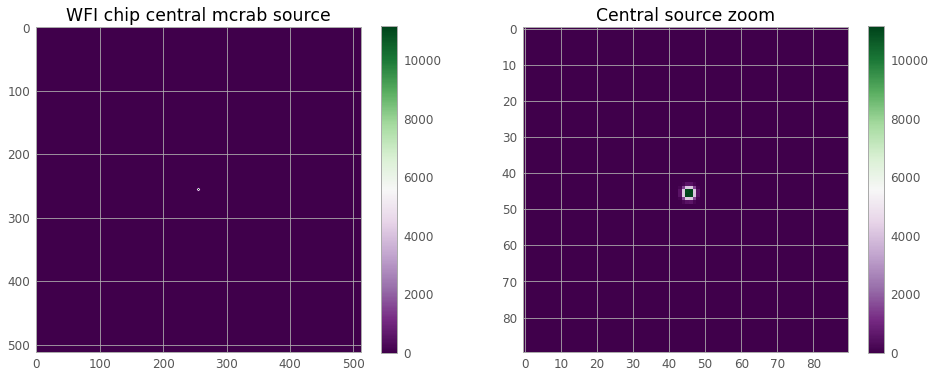

In [20]:
# Plot image
plt.clf()

image_data = fits.getdata(imgfile, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs = _axs.flatten()
cmap = plt.cm.PRGn

# Left plot
im = axs[0].imshow(image_data, cmap=cmap)
fig.colorbar(im,ax=axs[0])

# Zoomed plot
im = axs[1].imshow(image_data[210:300, 210:300], cmap=cmap)
fig.colorbar(im,ax=axs[1])

# Titles
axs[0].set_title("WFI chip central mcrab source")
axs[1].set_title("Central source zoom")

rt = 'imgs/imgev_general_intro.png'
img_subplot(fig, axs[1], a=1.6, b=1.2, route=rt)
run_comm('xdg-open {}'.format(rt))


In [21]:
# Create spectrum filtering the events with the condition given by "EventFilter" in the command
specfile = "spec_{}.pha".format(base)

rewrite = True
if rewrite:
    if os.path.exists(specfile):
            os.remove(specfile)
    comm = ("makespec EvtFile={} Spectrum={} clobber=yes RSPPath={}".format(evtfile, specfile, xmldir) +
            " EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' ")
    run_comm(comm, "Creating spectum with WFI")
else:
    print("Spectral file ({}) already exists: it will not be overwritten".format(specfile))
    


Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab.fits Spectrum=spec_mcrab.pha clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' 


In [22]:
f = fits.open(specfile)
f.info()
rmf = f[1].header['RESPFILE']
amf = f[1].header['ANCRFILE']

run_comm('ln -s {}'.format(rmf), 'Linking to working directory')
run_comm('ln -s {}'.format(amf), 'Linking to working directory')

Filename: spec_mcrab.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SPECTRUM      1 BinTableHDU     48   1498R x 2C   [J, J]   
Linking to working directory
ln -s /home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/athena_wfi_pirmf_v20190320.rmf
Command '['ln', '-s', '/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/athena_wfi_pirmf_v20190320.rmf']' returned non-zero exit status 1.


CalledProcessError: Command '['ln', '-s', '/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/athena_wfi_pirmf_v20190320.rmf']' returned non-zero exit status 1.

In [23]:
# fit spectrum in XSPEC
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s0 = Spectrum(specfile)
Plot.device = "/xs"
Plot.xAxis="KeV"
Plot('ldata')

In [24]:
# As there are bins with zero variance: ignore energy bands where signal to noise ratio is small
s0.ignore("**-0.3")
s0.ignore("4.0-**")
Plot('ldata')

In [11]:
# Define an absorbed power law model
m0 = Model("phabs*pow")

In [25]:
# rebin spectral data
binspec = "spec_{}_rebin.pha".format(base)

rewrite = True
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'".format(specfile, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

Rebinning spectrum
grppha infile=spec_mcrab.pha outfile=spec_mcrab_rebin.pha clobber=yes comm='group min 20 & exit'


### $\textbf{Exercise}$: Load rebinned PHA-file into XSPEC and fit an absorbed power-law to the 0.3-4 keV band


In [26]:
AllData.clear()
s1 = Spectrum(binspec)
s1.ignore("**-0.3")
s1.ignore("4.0-**")
Fit.perform()

Plot("ldata")
m0.show()
print("nH fit={:.3f}".format(m0.phabs.nH.values[0]))
print("Gamma fit={:.3f}".format(m0.powerlaw.PhoIndex.values[0]))


Exception: Error executing command: fit

In [27]:
# check PILEUP as the cause for spectral distortion (G~1.8 instead of G~2)
tmpFile = "pp{}.fits" .format(str(int(datetime.timestamp(datetime.now()))))
comm = ("fstatistic infile={} colname=PILEUP outfile={}".format(evtfile, tmpFile))
run_comm(comm,"Checking PILEUP")
f = open(tmpFile, 'r')
for line in f:
    print(repr(line))
os.remove(tmpFile)

Checking PILEUP
fstatistic infile=sim_evt_mcrab.fits colname=PILEUP outfile=pp1627925629.fits
' The sum of the selected column is                   5187.0000\n'
' The mean of the selected column is                 5.58721200E-02\n'
' The standard deviation of the selected column is   0.22967585\n'
' The minimum of selected column is                   0.0000000\n'
' The maximum of selected column is                   1.0000000\n'
' The number of points used in calculation is            92837\n'


### $\textbf{Exercise}$:  change the pointing direction of the instrument away from the source in steps of 4' in right ascension and declination simultaneously. Take a look at the images of the source and the source count rate. What do you observe?

0
********************************
Image for offset= 0 arcm
********************************
Simput file (mcrab_dec0.simput) already exists: it will not be overwritten
Simulation file (sim_evt_mcrab_dec0.fits) already exists: it will not be overwritten
Image file (img_mcrab_dec0.fits) already exists: it will not be overwritten
4
********************************
Image for offset= 4 arcm
********************************
Simput file (mcrab_dec4.simput) already exists: it will not be overwritten
Simulation file (sim_evt_mcrab_dec4.fits) already exists: it will not be overwritten
Image file (img_mcrab_dec4.fits) already exists: it will not be overwritten
8
********************************
Image for offset= 8 arcm
********************************
Simput file (mcrab_dec8.simput) already exists: it will not be overwritten
Simulation file (sim_evt_mcrab_dec8.fits) already exists: it will not be overwritten
Image file (img_mcrab_dec8.fits) already exists: it will not be overwritten


<Figure size 576x432 with 0 Axes>

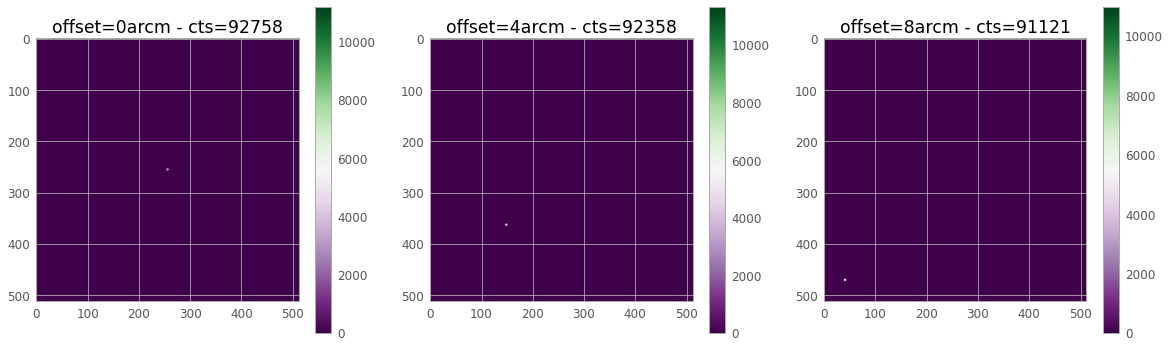

In [28]:
noffs = 3
clobber = False
flux = 2.16e-11
Elow = 0.1
Eup = 15
Emin = 2
Emax = 10
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)
plt.clf()
fig, _axs = plt.subplots(nrows=1, ncols=noffs, figsize=(20,6))
axs = _axs.flatten()
# Plotting 3 images of the source with the telescope moved away 4' and 8'
for ioff in range(0,(noffs*3),4):
    print(ioff)
    print("********************************")
    print("Image for offset=", ioff,"arcm")
    print("********************************")
    i = int(ioff/3.) 
    base_dec = "mcrab_dec" + str(ioff)
    ra = ioff/60
    dec_off = ioff/60. #deg
    expos = 1000
    simputfile_dec = base_dec + ".simput"
    
    # create simputfile
    if clobber:
        if os.path.exists(simputfile_dec):
            os.remove(simputfile_dec)
        create_simput_file(Simput=simputfile_dec, Src_Name=base_dec, RA=ra, Dec=dec_off, srcFlux=flux, Elow=Elow, Eup=Eup, 
                           Emin=Emin, Emax=Emax, XSPECFile=xcm, clobber="yes")
    else:
        print("Simput file ({}) already exists: it will not be overwritten".format(simputfile_dec))
        
    # run simulation
    evtfile_dec = "sim_evt_{}.fits".format(base_dec)
    if clobber:
        if os.path.exists(evtfile_dec):
            os.remove(evtfile_dec)
        run_simulation(XMLFile=xml, RA=ra, Dec=dec_off, Prefix='', Simput=simputfile_dec, EvtFile=evtfile_dec, Exposure=expos, clobber="yes")
    else:
        print("Simulation file ({}) already exists: it will not be overwritten".format(evtfile_dec))
    
    # create image
    imgfile_dec = "img_{}.fits".format(base_dec)
    if clobber:
        if os.path.exists(imgfile_dec):
            os.remove(imgfile_dec)
        create_image_WFI(EvtFile=evtfile_dec, Image=imgfile_dec, CoordinateSystem=0, Projection="TAN", NAXIS1=512, NAXIS2=512,
                         CUNIT1="deg", CUNIT2="deg", CRVAL1=0.0, CRVAL2=0.0, CRPIX1=256.5, CRPIX2=256.5,
                         CDELT1=-6.207043e-04, CDELT2=6.207043e-04)
    else:
        print("Image file ({}) already exists: it will not be overwritten".format(imgfile_dec))
    image_data = fits.getdata(imgfile_dec, ext=0)
    cmap = plt.cm.PRGn
    im = axs[i].imshow(image_data, cmap=cmap)
    fig.colorbar(im,ax=axs[i])
    tit = "offset=" + str(ioff) + "arcm - cts=" + str(np.sum(image_data))
    axs[i].set_title(tit)


### $\textbf{Exercise}$: in this exercise we continue studying the effects that bright sources have on the measurement process more. Using the Crab-like spectrum defined before, increase the source flux by a factor of 10, 100, and 1000 and redo the WFI simulation. Why can you prepare the simulation using mcrab.fits and fv, and without running simputfile?

### Calculate the count rates of the simulations by looking at the number of events in the file. What do you notice? Take a look at the X-ray spectrum of the 2nd brightest simulation and compare the observed photon spectrum with your input photon index. To get a better feeling for what is going on, plot the value of the FITS keywords NVALID, NPVALID, NINVALID, and NPINVALI as a function of the input flux. Why is the pile up fraction NPVALID/NVALID a good measure for the scientific quality of the data?



In [17]:
# Running the cells "Create an xspec model and save it as mcrab.xcm" and "Create SIMPUT FILE for source (simputfile)" is needed.
rewrite = False
f = fits.open('mcrab.fits')
extName = "SRC_CAT" 
# colnames = f[extName].columns.names --> Use it in order to obtain the columns name to change it below

initial_flux = f[extName].data["FLUX"]
j = 10
for i in range(1, 4):
    aux = 'mcrab{}.fits'.format(str(i+1))
    if not os.path.exists(aux):
        f[extName].data["FLUX"] = j ** i * initial_flux
        f.writeto(aux)
    elif rewrite:
        f2 = fits.open(aux, mode='update')
        f2[extName].data["FLUX"] = j ** i * initial_flux
        f2.flush()
    else:
        print("Simulation file ({}) already exists: it will not be overwritten".format(aux))
f.close()

# If the file does not exist, a new one is created. If exists, the file is opened and updated with the new info.

Simulation file (mcrab2.fits) already exists: it will not be overwritten
Simulation file (mcrab3.fits) already exists: it will not be overwritten
Simulation file (mcrab4.fits) already exists: it will not be overwritten


Events file (sim_evt_mcrab_fv0.fits) already exists: it will nott be overwritten
####################################################
Counts for flux=1 times mcrab source=[92979]
Valid events=92979 of which 5341 are piled-up
InValid events= 7776 of which 7603 are piled-up
Data quality= 0.9425569214553824
####################################################
Events file (sim_evt_mcrab_fv2.fits) already exists: it will nott be overwritten
####################################################
Counts for flux=10 times mcrab source=[92979, 147427]
Valid events=147427 of which 31214 are piled-up
InValid events= 170504 of which 169937 are piled-up
Data quality= 0.7882748750228927
####################################################
Events file (sim_evt_mcrab_fv3.fits) already exists: it will nott be overwritten
####################################################
Counts for flux=100 times mcrab source=[92979, 147427, 27368]
Valid events=27368 of which 616 are piled-up
InValid events= 201370 of 

Text(0, 0.5, 'Data Quality')

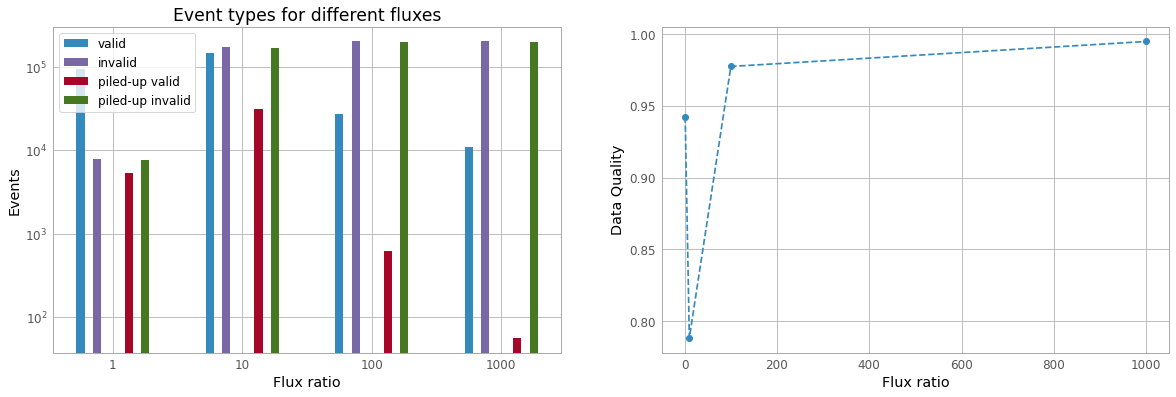

In [18]:
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)
evtfile = "sim_evt_{}.fits".format(base)
# Parameters for the simulation
RA = 0
Dec = 0
Prefix = ''
Exposure = 1000
cts = []
rewrite = False
clobber = True

flux_ratio = [1, 10, 100, 1000]

nvalid = []
npvalid = []
ninvalid = []
npinvali = []

Simput = 'mcrab.fits'
Evtfile = "sim_evt_{}_fv0.fits".format(base)

for i in range(0, 4):
    
    # Run simulation
    if rewrite:
        if os.path.exists(Evtfile):
            os.remove(Evtfile)
        run_simulation(xml, RA, Dec, Prefix, Simput, Evtfile, Exposure, clobber)
    else:
        print("Events file ({}) already exists: it will not be overwritten".format(Evtfile))
    
    # Save the parameters wanted of the event file in an empty list
    f = fits.open(Evtfile)
    tme = f['EVENTS'].data['TIME']
    cts.append(len(tme))
    
    nvalid.append(f['EVENTS'].header['NVALID'])
    npvalid.append(f['EVENTS'].header['NPVALID'])
    ninvalid.append(f['EVENTS'].header['NINVALID'])
    npinvali.append(f['EVENTS'].header['NPINVALI'])
    
    Simput = 'mcrab{}.fits'.format(str(i+2))
    Evtfile = "sim_evt_{}_fv{}.fits".format(base, str(i+2))
    
    data_quality = (1-npvalid[i]/nvalid[i])
    print("####################################################")
    print("Counts for flux={} times mcrab source={}".format(10**i, cts))
    print("Valid events={} of which {} are piled-up".format(nvalid[i], npvalid[i]))
    print("InValid events= {} of which {} are piled-up".format(ninvalid[i], npinvali[i]))
    print("Data quality=", data_quality)
    print("####################################################")
    f.close

nvalid = np.array(nvalid)
npvalid = np.array(npvalid)
ninvalid = np.array(ninvalid)
npinvali = np.array(npinvali)   

# Plot histogram of the data collected from the different simulations of the 4 fluxes.

fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axs = _axs.flatten()
flux_labels = ['1', '10', '100', '1000']
x = np.arange(len(flux_labels))
width = 0.25
axs[0].bar(x-width, nvalid, width/4, log=True, label="valid")
axs[0].bar(x-width/2, ninvalid, width/4, log=True, label="invalid")
axs[0].bar(x+width/2, npvalid, width/4, log=True,label="piled-up valid")
axs[0].bar(x+width, npinvali, width/4, log=True,label="piled-up invalid")
axs[0].set_xlabel("Flux ratio")
axs[0].set_ylabel('Events')
axs[0].set_title('Event types for different fluxes')
axs[0].set_xticks(x)
axs[0].set_xticklabels(flux_labels)
axs[0].legend()

data_quality = (1-npvalid/nvalid)

axs[1].plot(flux_ratio, data_quality, marker='o', linestyle='--')
axs[1].set_xlabel("Flux ratio")
axs[1].set_ylabel("Data Quality")

### $\textbf{Exercise}$: generate a SIMPUT file with a harder spectral shape (e.g., Γ = 1.5) than our example source and has the same flux. Place the source at a position that is 1000 away from our source. Merge both SIMPUT files with the simputmerge tool (use plist to learn about the parameters of this tool!). Then run a 5 ks simulation and study how well you can separate both sources.

    

In [31]:
# xspec file
base10 = "mcrab_10arcs"
xcm10 = base10 + ".xcm"
mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 1.5
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()

rewrite = True
if rewrite:
    if os.path.exists(xcm10):
        os.remove(xcm10)
    Xset.save(xcm10)
else:
    print("Xspec file ({}) already exists: it will not be overwritten".format(xcm10))
    
# simputfile
simputfile10 = base10 + ".simput"
ra = 0.0
dec = 10.0/3600 #deg
flux = 2.16E-11
Elow = 0.01 # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

if rewrite:
    if os.path.exists(simputfile10):
        os.remove(simputfile10)
    create_simput_file(Simput=simputfile10, Src_Name=base10, RA=ra, Dec=dec, srcFlux=flux, Elow=Elow, Eup=Eup, 
                       Emin=Emin, Emax=Emax, XSPECFile=xcm10, clobber="yes")
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simputfile10))

Creating simputfile
simputfile Simput=mcrab_10arcs.simput Src_Name=mcrab_10arcs RA=0.0 Dec=0.002777777777777778 srcFlux=2.16e-11 Elow=0.01 Eup=20. Emin=2 Emax=10. XSPECFile=mcrab_10arcs.xcm clobber=yes


In [32]:
# merge simput files
simput_merged10 = base + "_merged10.simput"
if rewrite:
    if os.path.exists(simput_merged10):
        os.remove(simput_merged10)
    comm = ("simputmerge Infile1={} Infile2={} Outfile={} clobber=yes".format(simputfile, simputfile10, simput_merged10))
    run_comm(comm, 'Merging files')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simput_merged10))

Merging files
simputmerge Infile1=mcrab.fits Infile2=mcrab_10arcs.simput Outfile=mcrab_merged10.simput clobber=yes


In [33]:
# run simulation
expos=5000
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)
evtfile_merged10 = "sim_evt_{}_merged10.fits".format(base)
rewrite = True

if rewrite:
    if os.path.exists(evtfile_merged10):
        os.remove(evtfile_merged10)
        
    run_simulation(XMLFile=xml, RA=0., Dec=0., Prefix="", Simput=simput_merged10, EvtFile=evtfile_merged10, 
                   Exposure=expos, clobber="yes")    
else:
    print("Simulations file ({}) already exists: it will not be overwritten".format(evtfile_merged10))

Simulating source with  WFI  instrument
runsixt XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_large.xml RA=0.0 Dec=0.0 Prefix= Simput=mcrab_merged10.simput EvtFile=sim_evt_mcrab_merged10.fits Exposure=5000 clobber=yes


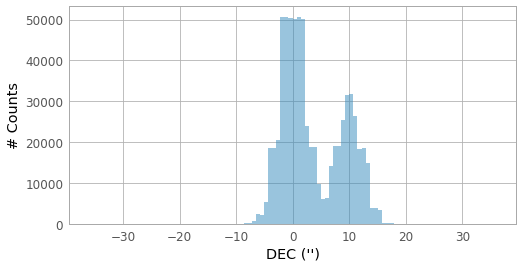

In [45]:
# study source separation (histogram of Dec positions) 
f = fits.open(evtfile_merged10)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("# Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.01) & (decVals<0.01)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)
fig.savefig('imgs/10_merged_hist.png', dpi=720)

### $\textbf{Exercise}$: repeat the previous exercise for a source separation of 5' and extract spectra for both sources. Generate corrected ARFs for the sources by adjusting the parameters of the sixte_arfgen call above and use your favorite X-ray spectral analysis program to see how the spectral shape is affected.

In [35]:
# xspec file
base5 = "mcrab_5arcs"
xcm5 = base5 + ".xcm"
mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 1.5
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()

rewrite = False
if rewrite:
    if os.path.exists(xcm10):
        os.remove(xcm10)
    Xset.save(xcm10)
else:
    print("Xspec file ({}) already exists: it will not be overwritten".format(xcm10))
    
# simputfile
simputfile5 = base5 + ".simput"
ra = 0.0
dec = 5.0/3600 #deg
flux = 2.16E-11
Elow = 0.01 # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

rewrite = True
if rewrite:
    if os.path.exists(simputfile5):
        os.remove(simputfile5)
    create_simput_file(Simput=simputfile5, Src_Name=base5, RA=ra, Dec=dec, srcFlux=flux, Elow=Elow, Eup=Eup, 
                       Emin=Emin, Emax=Emax, XSPECFile=xcm10, clobber="yes")
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simputfile5))

Xspec file (mcrab_10arcs.xcm) already exists: it will not be overwritten
Creating simputfile
simputfile Simput=mcrab_5arcs.simput Src_Name=mcrab_5arcs RA=0.0 Dec=0.001388888888888889 srcFlux=2.16e-11 Elow=0.01 Eup=20. Emin=2 Emax=10. XSPECFile=mcrab_10arcs.xcm clobber=yes


In [36]:
# merge simput files
simput_merged5 = base + "_merged5.simput"
if rewrite:
    if os.path.exists(simput_merged5):
        os.remove(simput_merged5)
    comm = ("simputmerge Infile1={} Infile2={} Outfile={} clobber=yes".format(simputfile, simputfile5, simput_merged5))
    run_comm(comm, 'Merging files')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(simput_merged5))

Merging files
simputmerge Infile1=mcrab.fits Infile2=mcrab_5arcs.simput Outfile=mcrab_merged5.simput clobber=yes


In [37]:
# run simulation
base = 'mcrab'
expos=5000
evtfile_merged5 = "sim_evt_{}_merged5.fits".format(base)
rewrite = True

if rewrite:
    if os.path.exists(evtfile_merged5):
        os.remove(evtfile_merged5)
        
    run_simulation(XMLFile=xml, RA=0., Dec=0., Prefix="", Simput=simput_merged5, EvtFile=evtfile_merged5, 
                   Exposure=expos, clobber="yes")    
else:
    print("Simulations file ({}) already exists: it will not be overwritten".format(evtfile_merged5))

Simulating source with  WFI  instrument
runsixt XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_large.xml RA=0.0 Dec=0.0 Prefix= Simput=mcrab_merged5.simput EvtFile=sim_evt_mcrab_merged5.fits Exposure=5000 clobber=yes


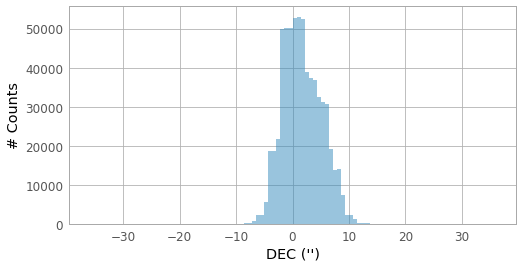

In [41]:
# study source separation (histogram of Dec positions)
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("# Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.01) & (decVals<0.01)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)

In [39]:
#create spectrum
base = 'mcrab'
evtfile = "sim_evt_{}_merged5.fits".format(base)
specs = list()
evtfilts = list()
rebins = list()

# SRC @ centre
radInDeg = 5./3600.
RAmin = 360.-radInDeg
RAmax = 0.+radInDeg
DECmin = -radInDeg
DECmax = radInDeg
evtfilts.append("'(RA>{}|| RA<{}) && Dec>{}&& Dec<+{}'".format(str(RAmin), str(RAmax), str(DECmin), str(DECmax)))
specs.append("spec0_{}_merged5.fits".format(base))
rebins.append("spec0_{}_merged5.grp".format(base))

# SRC @ 5" off DEC
DECmin = 5./3600 - radInDeg
DECmax = 5./3600 + radInDeg
specs.append("spec5_{}_merged5.fits".format(base))
rebins.append("spec5_{}_merged5.grp".format(base))
evtfilts.append("'(RA>{}|| RA<{}) && Dec>{}&& Dec<+{}'".format(str(RAmin), str(RAmax), str(DECmin), str(DECmax)))
rewrite = True
for i in range(len(specs)):
    if rewrite:
        if os.path.exists(specs[i]):
            os.remove(specs[i])
        create_spec(EvtFile=evtfile, Spectrum=specs[i], clobber="yes", RSPPath=xmldir, EventFilter=evtfilts[i])
        comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'" .format(specs[i], rebins[i]))  
        run_comm(comm, 'Rebinning spectrum')
        
    else:
        print("Spectral file ({}) already exists: it will not be overwritten".format(specs[i]))
print(tme)

Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab_merged5.fits Spectrum=spec0_mcrab_merged5.fits clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row EventFilter='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>-0.001388888888888889&& Dec<+0.001388888888888889'
Rebinning spectrum
grppha infile=spec0_mcrab_merged5.fits outfile=spec0_mcrab_merged5.grp clobber=yes comm='group min 20 & exit'
Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab_merged5.fits Spectrum=spec5_mcrab_merged5.fits clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row EventFilter='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>0.0&& Dec<+0.002777777777777778'
Rebinning spectrum
grppha infile=spec5_mcrab_merged5.fits outfile=spec5_mcrab_merged5.grp clobber=yes comm='group min 20 & exit'


NameError: name 'tme' is not defined

In [61]:
# fit spectra to show variation of spectral shape wrt mcrab original isolated source. Remember to run the first simulation in order to ge s0 spectrum
Plot.device = '/null'
AllData.clear()
AllModels.clear()
Plot.device = "/xs"
Plot.xAxis="KeV"
m = Model("phabs*pow")
s0 = Spectrum(rebins[0])
s0.ignore("**-0.3")
s0.ignore("4.0-**")

Fit.perform()
Plot("ldata")
print("nH fit={:.3f}".format(m. phabs.nH.values[0]))
print("Gamma fit={:.3f}".format(m. powerlaw.PhoIndex.values[0]))

time.sleep(5) # Add delay to distinguish the plots

AllData.clear()
s5 = Spectrum(rebins[1])
s5.ignore("**-0.3")
s5.ignore("4.0-**")

Fit.perform()
Plot("ldata")
print("nH fit={:.3f}".format(m. phabs.nH.values[0]))
print("Gamma fit={:.3f}".format(m. powerlaw.PhoIndex.values[0]))

nH fit=0.157
Gamma fit=1.640
nH fit=0.158
Gamma fit=1.503


### $\textbf{Exercise}$: in order to quantify the mixing of photons from both sources further, we can take a look at the diagnostic information contained in the event file. Specifically, use the FTOOL fselect and, using the row selection syntax, generate a new event file for one of the two sources by selecting the events in the region around the source. Determine the fraction of photons from the other source that “contaminate” the selection region by using the information in the SRC_ID column of the event file. For each event, this column contains information about the source in which it originated, in form of the ID of that source in the SIMPUT file.


In [63]:
evtfile = "sim_evt_{}_merged5.fits".format(base)
evts = ("sim_evt_{}0_merged5.fits", "sim_evt_{}5_merged5.fits".format(base))
for i in range(len(evtfilts)):
    comm = ("fselect infile={}+1 outfile={} expr={} clobber=yes".format(evtfile, evts[i], evtfilts[i]))
    run_comm(comm, "Selecting events for source {}".format(i))
    

Selecting events for source 0
fselect infile=sim_evt_mcrab_merged5.fits+1 outfile=sim_evt_{}0_merged5.fits expr='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>-0.001388888888888889&& Dec<+0.001388888888888889' clobber=yes
Selecting events for source 1
fselect infile=sim_evt_mcrab_merged5.fits+1 outfile=sim_evt_mcrab5_merged5.fits expr='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>0.0&& Dec<+0.002777777777777778' clobber=yes


In [64]:
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
print("Total number of photons in both sources (central & 5' offset)=",data.shape[0])
f.close
f = fits.open(evts[0])
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph2 =len(idVals[idVals[:,0]==2][:,0])
print("SRC1: Number of photons of src2 (5'' offset) = ", nph2)
f = fits.open(evts[1])
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph1 =len(idVals[idVals[:,0]==1][:,0])
print("SRC2: Number of photons of src1 (central) = ", nph1)


Total number of photons in both sources (central & 5' offset)= 664360
SRC1: Number of photons of src2 (5'' offset) =  99582
SRC2: Number of photons of src1 (central) =  201811
